In [1]:
# %pip install seqlogo
import pandas as pd
import numpy as np
from collections import namedtuple

In [ ]:
dd = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
dd

In [2]:
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from weblogolib import *
from corebio.seq import Alphabet

# amino acid 서열 데이터를 포함하는 FASTA 파일의 경로를 정합니다. (예: aa_sequences.fasta)
input_file = "aa_sequences.fasta"

# 결과로 나올 seqlogo 이미지의 파일과 출력 형식을 정합니다. (예: aa_seqlogo.eps)
output_file = "aa_seqlogo.eps"
output_format = "eps"

# SeqIO를 사용하여 amino acid 서열 데이터를 읽어옵니다.
sequences = list(SeqIO.parse(input_file, "fasta", alphabet=IUPAC.protein))

# WebLogo용 데이터 형식으로 변환합니다.
weblogo_sequences = []
for seq_record in sequences:
    weblogo_sequences.append(SeqRecord(Seq(str(seq_record.seq), Alphabet()), id=seq_record.id))

# WebLogo를 생성하는 options를 설정합니다.
fin = LogoData.from_seqs(weblogo_sequences)
fout = LogoFormat(fin, LogoOptions())

# 설정한 출력 형식에 맞춰 SeqLogo 이미지 파일을 작성합니다.
with open(output_file, "wb") as f:
    f.write(formatter(fout, format=output_format))

print("SeqLogo 이미지 파일이 작성되었습니다:", output_file)


ImportError: Bio.Alphabet has been removed from Biopython. In many cases, the alphabet can simply be ignored and removed from scripts. In a few cases, you may need to specify the ``molecule_type`` as an annotation on a SeqRecord for your script to work correctly. Please see https://biopython.org/wiki/Alphabet for more information.

<Axes: >

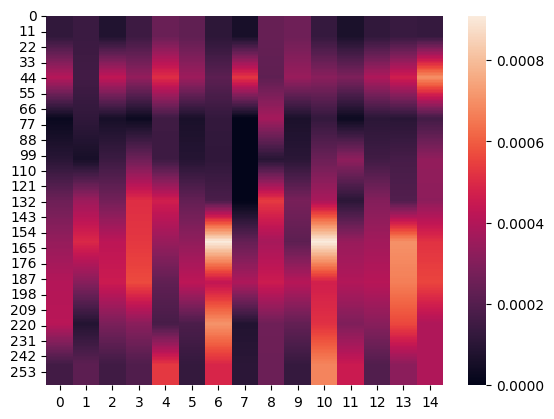

In [166]:
plt.Figure(figsize=(50, 10))
sns.heatmap(family_gradcam['gradcam_resize']['ALK'])

In [125]:
dd = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
pairs = dd['kin_id'] + '_' + dd['subseq']
total_pair_mapping = {pair: total_pair for pair, total_pair in zip(dd['pair'], pairs)}
total_pair_mapping

{'O00506_NLSAAQTLRAAFI': 'O00506_VNLSAAQTLRAAFIK',
 'O14733_NRSGAMSPMSWNS': 'O14733_QNRSGAMSPMSWNSD',
 'O14920_TGSGIKSHNSALY': 'O14920_ATGSGIKSHNSALYS',
 'O14920_HPLSLTSDQYKAY': 'O14920_SHPLSLTSDQYKAYL',
 'O14920_PPYADPSLQAPVR': 'O14920_TPPYADPSLQAPVRV',
 'O14920_HSPLSLSAQSVME': 'O14920_GHSPLSLSAQSVMEE',
 'O14920_GIKSHNSALYSQV': 'O14920_SGIKSHNSALYSQVQ',
 'O14920_SIRLQISNPDLKD': 'O14920_DSIRLQISNPDLKDR',
 'O14920_LDDRHDSGLDSMK': 'O14920_LLDDRHDSGLDSMKD',
 'O14920_YKCEGRSAGSIPG': 'O14920_RYKCEGRSAGSIPGE',
 'O14920_TYETFKSIMKKSP': 'O14920_RTYETFKSIMKKSPF',
 'O14920_SNSHPLSLTSDQY': 'O14920_ISNSHPLSLTSDQYK',
 'O14920_SPFYRDSLPGSQR': 'O14920_DSPFYRDSLPGSQRK',
 'O14920_DLEQAISQRIQTN': 'O14920_RDLEQAISQRIQTNN',
 'O14920_EMSSSHSAQSMVS': 'O14920_GEMSSSHSAQSMVSG',
 'O14920_FHSLPFSLTKMPN': 'O14920_RFHSLPFSLTKMPNT',
 'O14920_DIFSSVSVPPSLK': 'O14920_PDIFSSVSVPPSLKV',
 'O14920_KELDQGSLCTSFV': 'O14920_AKELDQGSLCTSFVG',
 'O14920_LSLSAQSVMEELN': 'O14920_PLSLSAQSVMEELNT',
 'O14920_AFGGYLSEVVEEN': 'O1492

In [129]:
kinmap = pd.read_csv("../kinase_family_kinmap.csv")
df = pd.read_pickle("grad_cam_result.pkl")
del df['grad_cam'], df['grad_cam_pp']
df.head(5)

,pair,kinase,uniprotID,substrate,family,group,gradcam_resize,gradcam_pp_resize,flatten_gradcam
0,Q9UM73_RVCSLCYRELAAQ,ALK,Q9UM73,RVCSLCYRELAAQ,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...","[[0.0205638, 0.05325572, 0.06773758, 0.1056384...","[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...."
1,Q9UM73_GLARDIYKDPDYV,ALK,Q9UM73,GLARDIYKDPDYV,ALK,TK,"[[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0,...","[[0.033400796, 0.0, 0.09327865, 0.0, 0.0822797...","[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0, ..."
2,Q9UM73_YRPSYSYDYEFDL,ALK,Q9UM73,YRPSYSYDYEFDL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.96...","[[0.0, 0.0, 0.0, 0.0, 0.11245741, 0.0, 0.11245...","[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.963..."
3,P29376_RRAPELYRAPFPL,LTK,P29376,RRAPELYRAPFPL,ALK,TK,"[[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, ...","[[0.0625958, 0.0625958, 0.0625958, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, 0..."
4,Q9UM73_KQVEELYHSLLEL,ALK,Q9UM73,KQVEELYHSLLEL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.0004413...","[[0.0, 0.109487526, 0.0, 0.114758596, 0.116214...","[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.00044131..."


In [130]:
df_total_pair = df['pair'].apply(lambda x: total_pair_mapping[x])
df.insert(0, 'total_pair', df_total_pair)
df['substrate15'] = df['total_pair'].apply(lambda x: x.split('_')[1])
df

,total_pair,pair,kinase,uniprotID,substrate,family,group,gradcam_resize,gradcam_pp_resize,flatten_gradcam,substrate15
0,Q9UM73_LRVCSLCYRELAAQK,Q9UM73_RVCSLCYRELAAQ,ALK,Q9UM73,RVCSLCYRELAAQ,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...","[[0.0205638, 0.05325572, 0.06773758, 0.1056384...","[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0....",LRVCSLCYRELAAQK
1,Q9UM73_FGLARDIYKDPDYVR,Q9UM73_GLARDIYKDPDYV,ALK,Q9UM73,GLARDIYKDPDYV,ALK,TK,"[[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0,...","[[0.033400796, 0.0, 0.09327865, 0.0, 0.0822797...","[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0, ...",FGLARDIYKDPDYVR
2,Q9UM73_PYRPSYSYDYEFDLG,Q9UM73_YRPSYSYDYEFDL,ALK,Q9UM73,YRPSYSYDYEFDL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.96...","[[0.0, 0.0, 0.0, 0.0, 0.11245741, 0.0, 0.11245...","[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.963...",PYRPSYSYDYEFDLG
3,P29376_RRRAPELYRAPFPLY,P29376_RRAPELYRAPFPL,LTK,P29376,RRAPELYRAPFPL,ALK,TK,"[[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, ...","[[0.0625958, 0.0625958, 0.0625958, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, 0...",RRRAPELYRAPFPLY
4,Q9UM73_MKQVEELYHSLLELG,Q9UM73_KQVEELYHSLLEL,ALK,Q9UM73,KQVEELYHSLLEL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.0004413...","[[0.0, 0.109487526, 0.0, 0.114758596, 0.116214...","[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.00044131...",MKQVEELYHSLLELG
...,...,...,...,...,...,...,...,...,...,...,...
21150,Q9BYP7_KRASFAKSVIGTPEF,Q9BYP7_RASFAKSVIGTPE,Wnk3,Q9BYP7,RASFAKSVIGTPE,WNK,Other,"[[0.0, 0.0, 1.0144075e-05, 0.0, 0.0, 1.0144075...","[[0.0, 0.16088328, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 1.0144075e-05, 0.0, 0.0, 1.0144075e...",KRASFAKSVIGTPEF
21151,Q9BYP7_IEDLSQNSITGEHSQ,Q9BYP7_EDLSQNSITGEHS,Wnk3,Q9BYP7,EDLSQNSITGEHS,WNK,Other,"[[0.00023869786, 0.0023622129, 0.00017016295, ...","[[0.0, 0.3588531, 0.38790095, 0.0, 0.0, 0.0731...","[0.00023869786, 0.0023622129, 0.00017016295, 0...",IEDLSQNSITGEHSQ
21152,Q9H4A3_VRRVPGSSGRLHKTE,Q9H4A3_RRVPGSSGRLHKT,Wnk1,Q9H4A3,RRVPGSSGRLHKT,WNK,Other,"[[0.0005799708, 0.0, 0.0, 0.0005799708, 0.0005...","[[0.0, 0.0195809, 0.0195809, 0.0, 0.0, 0.0, 0....","[0.0005799708, 0.0, 0.0, 0.0005799708, 0.00056...",VRRVPGSSGRLHKTE
21153,Q9BYP7_FRGDRCRSLTGKPKL,Q9BYP7_RGDRCRSLTGKPK,Wnk3,Q9BYP7,RGDRCRSLTGKPK,WNK,Other,"[[6.855685e-05, 6.715357e-05, 0.00032500437, 0...","[[0.022324264, 0.085167415, 0.0, 0.08731468, 0...","[6.855685e-05, 6.715357e-05, 0.00032500437, 0....",FRGDRCRSLTGKPKL


In [131]:
alk = df[df['kinase'] == 'ALK']
sequences = [x for x in alk.substrate15]

In [ ]:
import weblogo
from Bio import SeqIO

def create_seq_logo(sequence_file):
    # 서열 파일을 읽어옵니다.
    sequences = SeqIO.parse(sequence_file, "fasta")

    # 웹로고 옵션 설정
    options = weblogo.LogoOptions()
    options.unit_name = "probability"
    options.fineprint = ""
    options.color_scheme = weblogo.colorscheme.nucleotide

    # 웹로고 데이터 생성
    data = weblogo.LogoData.from_seqs(sequences)
    data.composition()

    # 시퀀스 로고 생성
    seq_logo = weblogo.LogoFormat(data, options)

    # 시퀀스 로고 이미지 저장
    output_file = "seq_logo.png"
    with open(output_file, "w") as f:
        seq_logo.print_png(f, resolution=300)

    print(f"시퀀스 로고가 생성되었습니다. 파일명: {output_file}")


# 아래는 테스트용으로 예시 서열 파일을 사용합니다.
sequence_file = "example.fasta"

# 시퀀스 로고 생성 함수 호출
create_seq_logo(sequence_file)


In [16]:
data = weblogo.seq.SeqList(sequences)

In [20]:
import numpy as np
import pandas as pd
import seqlogo

In [37]:
t = ''.join([x for x in df['substrate'].unique()])
yes = []
for chr in t:
    if chr not in yes:
        yes.append(chr)
yes.sort()

yes_ = "".join(yes)

In [139]:
freq = pd.DataFrame(np.zeros(shape=(15, 20)), columns=yes, index=range(0, 15))

for sub in sequences:
    sub = list(sub)
    for i, aa in enumerate(sub):
        if freq[aa][i] >=1:
            freq[aa][i] += 1
        else:
            freq[aa][i] = 1 

for i in range(len(freq)):
    freq.iloc[i] = freq.iloc[i] / sum(freq.iloc[i])

In [142]:
freq = seqlogo.Pfm(freq, alphabet_type='AA')
type(freq)

seqlogo.core.Pfm

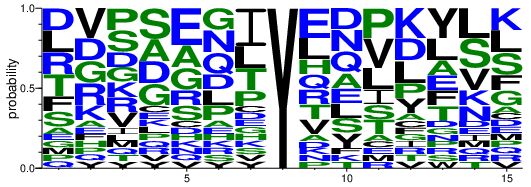

In [158]:
# ppm = seqlogo.Ppm(freq)
seqlogo.seqlogo(freq, ic_scale = False, format = 'png', size = 'medium')

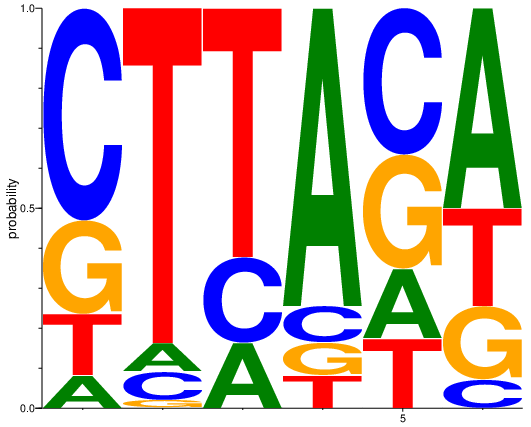

In [69]:
>>> np.random.seed(42)

# Making a fake PWM
>>> random_ppm = np.random.dirichlet(np.ones(4), size=6)
>>> ppm = seqlogo.Ppm(random_ppm)
>>> seqlogo.seqlogo(ppm, ic_scale = False, format = 'png', size = 'medium')

In [30]:
# Setting seed for demonstration purposes
>>> np.random.seed(42)

# Making some fake Position Frequency Data (PFM)
>>> pfm = pd.DataFrame(np.random.randint(0, 36, size=(8, 4)))

# Convert to Position Weight Matrix (PWM)
>>> pwm = seqlogo.pfm2pwm(pfm)
>>> pwm

,A,C,G,T
0,0.698830,-0.301170,-1.301170,0.213404
1,0.263034,0.552541,-0.584962,-0.584962
2,0.148523,0.754244,0.148523,-3.375039
3,0.182864,-4.209453,0.314109,0.648528
4,-4.000000,0.321928,1.000000,-0.540568
5,-0.222392,-0.029747,0.085730,0.140178
6,0.697437,0.597902,-2.209453,-0.624491
7,0.736966,-0.584962,0.502500,-2.000000


In [19]:
from weblogo import *
# fin = open('cap.fa')
seqs = read_seq_data(sequences)
logodata = LogoData.from_seqs(seqs)
logooptions = LogoOptions()
logooptions.title = "A Logo Title"
logoformat = LogoFormat(logodata, logooptions)
eps = eps_formatter(logodata, logoformat)

AttributeError: 'list' object has no attribute 'seek'

In [12]:
import weblogo

options = weblogo.LogoOptions()
options.unit_name = "probability"
options.fineprint = ""
options.color_scheme = weblogo.colorscheme.nucleotide

# 웹로고 데이터 생성
data = weblogo.LogoData.from_seqs(sequences)
data.composition()

# 시퀀스 로고 생성
seq_logo = weblogo.LogoFormat(data, options)

# 시퀀스 로고 이미지 저장
output_file = "seq_logo.png"
with open(output_file, "w") as f:
    seq_logo.print_png(f, resolution=300)

print(f"시퀀스 로고가 생성되었습니다. 파일명: {output_file}")

AttributeError: 'list' object has no attribute 'profile'

In [9]:
from Bio import motifs
import matplotlib.pyplot as plt

# 아미노산 서열 리스트 생성
alk = df[df['kinase'] == 'ALK']
sequences = [x for x in alk.substrate]

# motifs 객체 생성
motif = motifs.create(sequences)

# seqlogo 생성
seqlogo = motif.logo()

# seqlogo 그리기
seqlogo.plot(figsize=(8, 4.5), color_scheme='colorblind')
plt.title("Seqlogo")
plt.xlabel("Position")
plt.ylabel("Bits")
plt.tight_layout()

# 그림 출력
plt.show()


KeyError: 'R'